# Principal component analysis of the dataset
## 1. Library imports and setup

In [2]:
library(tidyverse)
library(factoextra)
library(cowplot)

In [3]:
Sys.setenv(LANGUAGE="en")
Sys.setlocale("LC_TIME", "English")

theme_set(theme_bw())

[1] "English_United States.1252"

In [4]:
pca.theme <- theme(text = element_text(size = 16),
                   axis.title = element_text(size = 18),
                   axis.text = element_text(size = 18),
                   legend.text= element_text(size = 14))

site.color <- c(`GF`='#E41A1C', `H`='#FF7F00', `S1`="blue" , `S2`='#377EB8')

#### Flag determining if plots are to be dumped in the form of files

In [5]:
#flag.make.plots <- TRUE
flag.make.plots <- FALSE

#### Determining the dpi and the image output path for publication high quality plots

In [6]:
dpi.opt <- 1000

In [7]:
IMG.path <- "../../IMG"

## 2. Import of the clean data

In [8]:
data.path <- "../../data"

file.name <- "df_chem_merged.rds"
df.chem.merged <- readRDS(paste0(data.path,"/",file.name))
head(df.chem.merged,3)

file.name <- "df_v_merged.rds"
df.v.merged <- readRDS(paste0(data.path,"/",file.name))
head(df.v.merged,3)

,ix,date_time,ec,temp,light,oxygen,pH,water_level,chlorophyll.a,chlorophyll.red,⋯,pH.upd,light.upd,salinity.upd,sensor.depth,depth,kelp,site,m.yr.factor,w.yr.factor,water.depth
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>,<fct>,<ord>,<ord>,<dbl>
1,7m_G-1,2021-08-12 08:00:00,31194.1,4.71,688.9,13.50,8.35,216.510,6,11,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,NA
2,7m_G-2,2021-08-12 08:30:00,31219.2,4.32,667.4,13.54,8.34,216.356,8,21,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,NA
3,7m_G-3,2021-08-12 09:00:00,31319.6,5.29,796.5,13.31,8.35,179.936,6,54,⋯,NA,NA,NA,NA,7 [m],FALSE,GF,Aug21,W32-21,8.068685


,date_time,speed,heading,velocityN,velocityE,depth,site,kelp,m.yr.factor,w.yr.factor,depth.raw
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>,<fct>,<ord>,<ord>,<fct>
1,2021-08-13 00:00:00,1.89,180.44,-1.89,-0.01,7 [m],GF,FALSE,Aug21,W33-21,7
2,2021-08-13 00:05:00,1.64,177.22,-1.63,0.08,7 [m],GF,FALSE,Aug21,W33-21,7
3,2021-08-13 00:10:00,1.85,177.76,-1.85,0.07,7 [m],GF,FALSE,Aug21,W33-21,7


## 3. PCA

#### Merging data frames using common timestep

In [9]:
df.velocity.30min <-  df.v.merged %>%
  mutate(date_time = floor_date(date_time, unit = "30 min")) %>%
  group_by(site,depth,date_time) %>%
  summarise(speed = mean(speed, na.rm = TRUE),
            velocityN = mean(velocityN, na.rm = TRUE),
            velocityE = mean(velocityE, na.rm = TRUE))

head(df.velocity.30min,3)

`summarise()` has grouped output by 'site', 'depth'. You can override using the
`.groups` argument.


site,depth,date_time,speed,velocityN,velocityE
<fct>,<ord>,<dttm>,<dbl>,<dbl>,<dbl>
GF,7 [m],2021-08-13 00:00:00,1.980000,-1.900000,-0.3050000
GF,7 [m],2021-08-13 00:30:00,2.693333,-1.281667,1.6366667
GF,7 [m],2021-08-13 01:00:00,1.900000,-1.053333,0.1516667


In [10]:
df.all2 <- merge(x=df.chem.merged, y= df.velocity.30min, by=c("site","depth","date_time"))
colnames(df.all2)[match('ec',colnames(df.all2))] <- "EC" # change the lowercase name ec to uppercase EC
nrow(df.all2)
head(df.all2,3)

[1] 493301

,site,depth,date_time,ix,EC,temp,light,oxygen,pH,water_level,⋯,light.upd,salinity.upd,sensor.depth,kelp,m.yr.factor,w.yr.factor,water.depth,speed,velocityN,velocityE
,<fct>,<ord>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>
1,GF,10 [m],2021-08-13 00:00:00,10m_G-33,30120.4,5.25,64.6,13.17,8.37,NA,⋯,64.6,32.9891,NA,FALSE,Aug21,W32-21,NA,2.918333,-1.3650000,2.348333
2,GF,10 [m],2021-08-13 00:30:00,10m_G-34,30095.0,5.14,64.6,13.14,8.36,NA,⋯,64.6,33.0673,NA,FALSE,Aug21,W33-21,NA,2.253333,0.4533333,2.181667
3,GF,10 [m],2021-08-13 01:00:00,10m_G-35,30007.3,4.85,53.8,13.27,8.37,NA,⋯,53.8,33.2496,NA,FALSE,Aug21,W33-21,NA,1.998333,0.9583333,1.751667


In [11]:
featX <- c('oxygen','pH',"EC",'temp','light','velocityN','velocityE')
df.all2 <- na.omit(df.all2[c(featX,"site","depth","kelp")])
nrow(df.all2)
res.pca <- prcomp(df.all2[featX], scale = TRUE)

[1] 246520

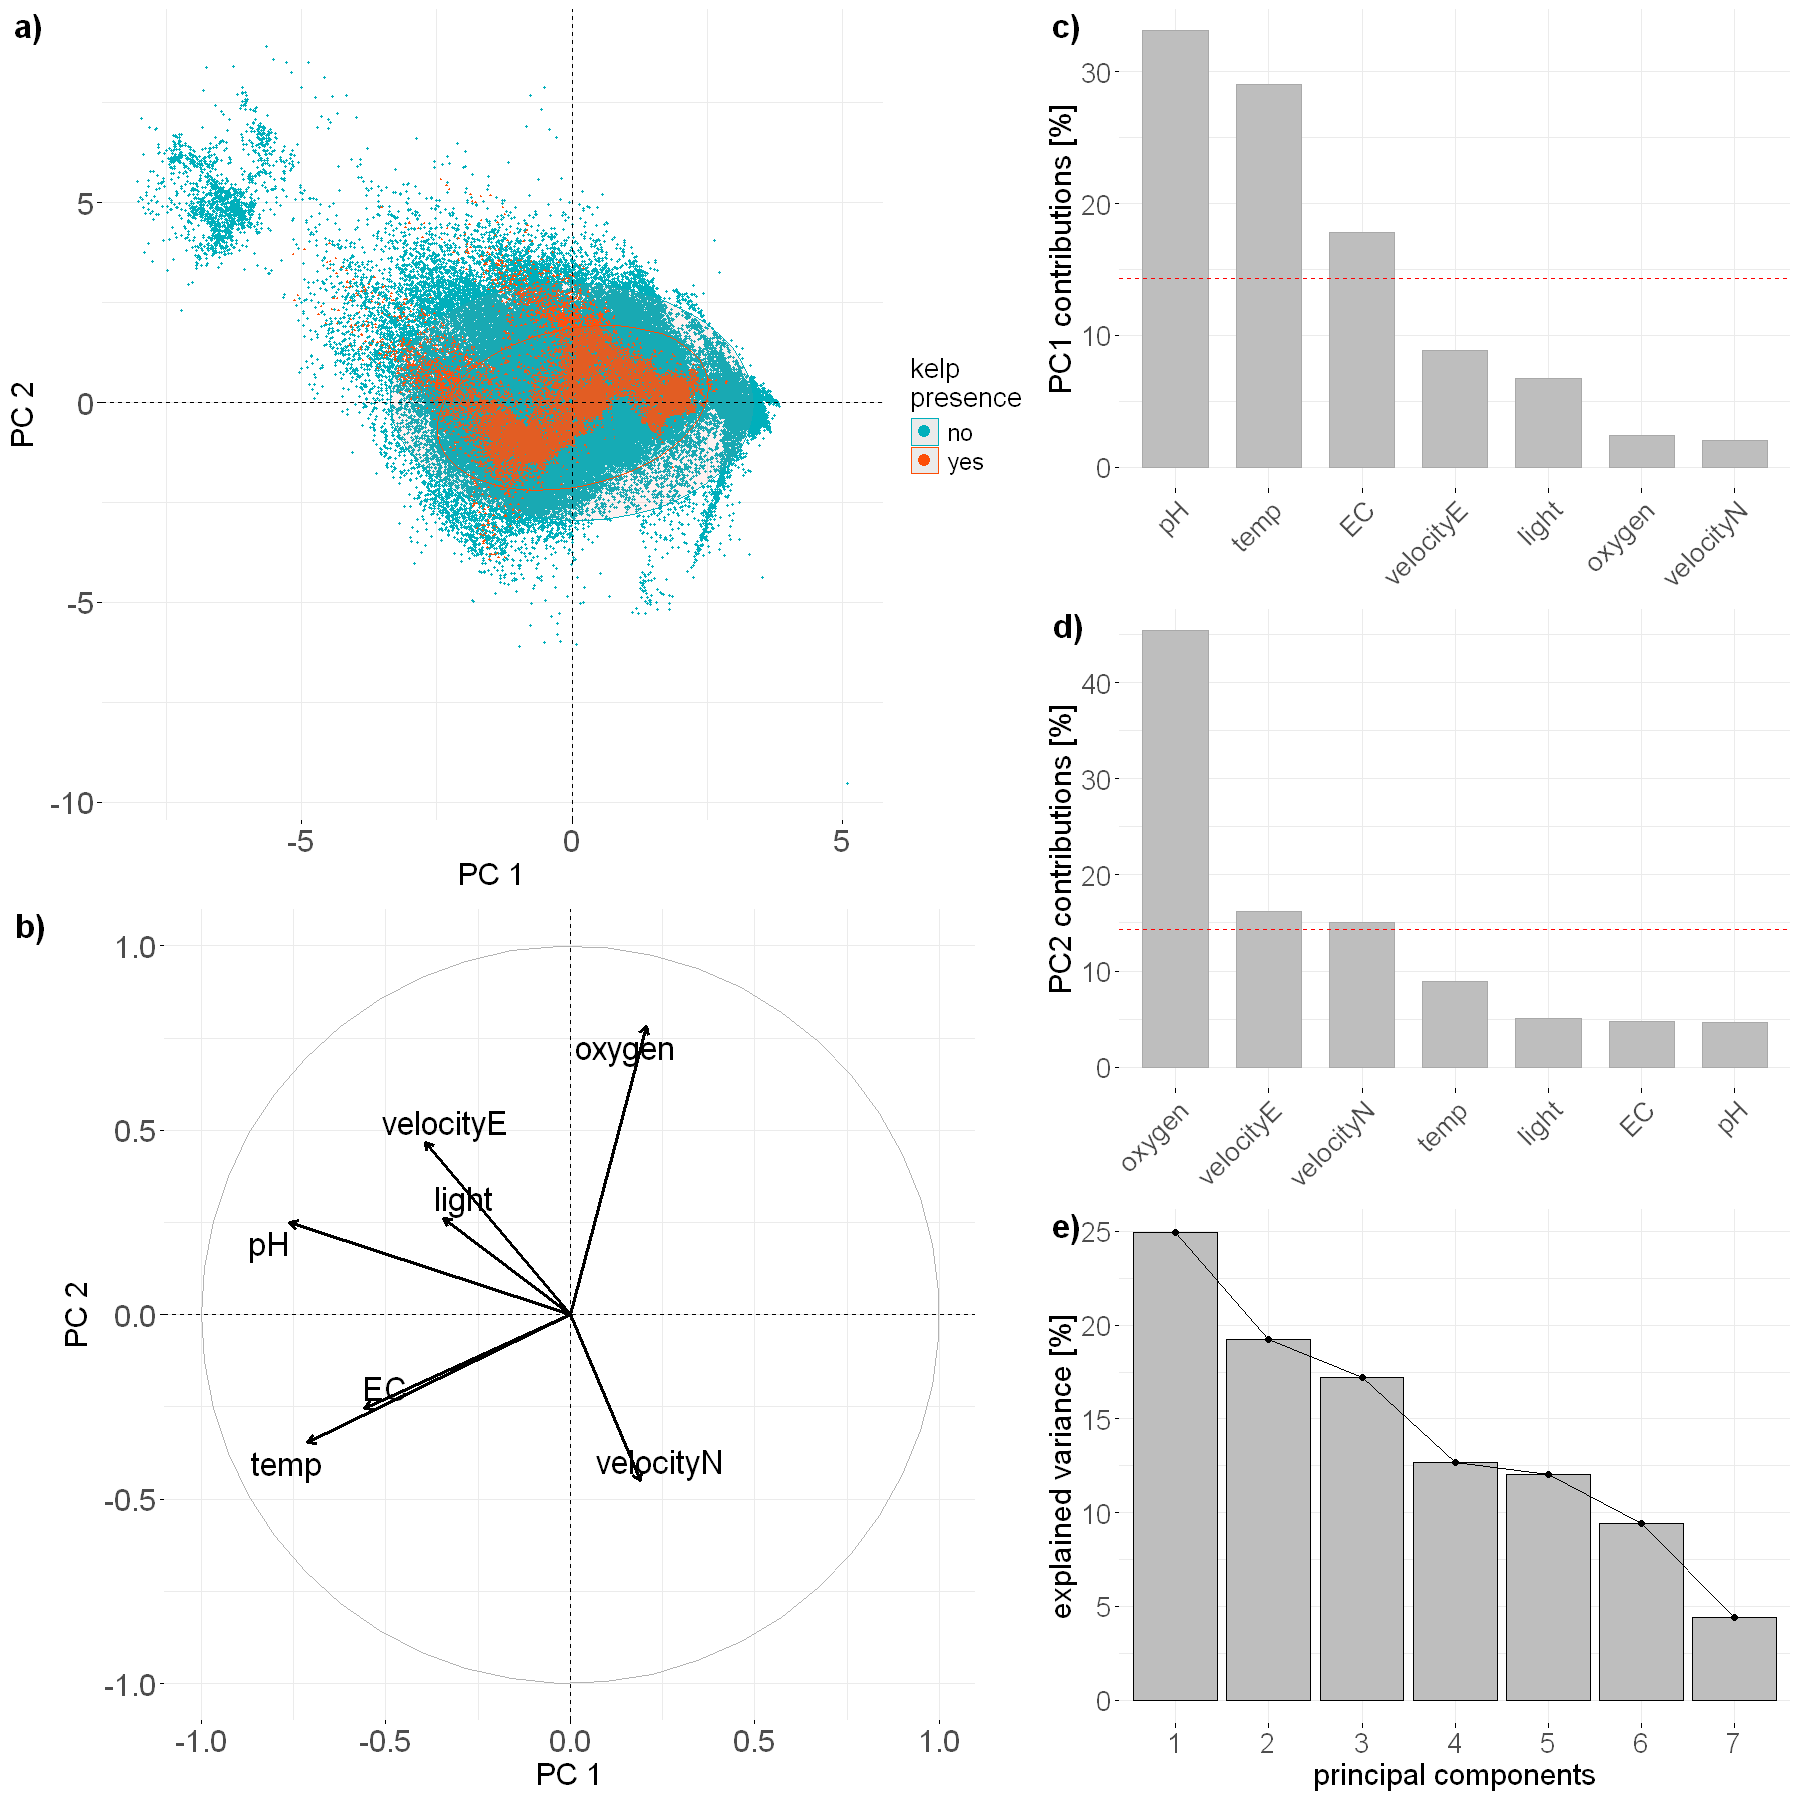

In [12]:
options(repr.plot.width=15,repr.plot.height=15)
plot.pc1 <- fviz_pca_ind(res.pca,
             habillage=factor(df.all2$kelp),
              geom.ind="point",
             addEllipses=TRUE, 
             ellipse.level=0.95,labelsize = 0,pointsize=0.4,title=NULL ) +  
             labs(title = NULL,x = "PC 1", y = "PC 2") +
             guides(color = guide_legend(override.aes = list(size=3))) +
             scale_color_manual(name="kelp\npresence", values=c('FALSE'="#00AFBB",  'TRUE'="#FC4E07"), labels=c("no","yes"))+
             guides( size = "none" ,shape="none",fill="none") +
             pca.theme 


plot.pc2 <- fviz_pca_var(res.pca, col.var = "black",title=NULL,repel=TRUE,labelsize = 7,arrowsize = 1) +             
             labs(title = NULL,x = "PC 1", y = "PC 2") +
             pca.theme 

# Contributions of variables to PC1
plot.pc3 <- fviz_contrib(res.pca, choice = "var", axes = 1, top = ncol(res.pca$x),fill = "gray",color="darkgray") +
             labs(title = NULL,x = "variables", y = "PC1 contributions [%]") +
             pca.theme + theme(axis.text = element_text(size = 16))
# Contributions of variables to PC2
plot.pc4 <- fviz_contrib(res.pca, choice = "var", axes = 2, top = ncol(res.pca$x),fill = "gray",color="darkgray") +
             labs(title = NULL,x = "variables", y = "PC2 contributions [%]") +
             pca.theme + theme(axis.text = element_text(size = 16))

plot.pc5 <- fviz_eig(res.pca,ncp=ncol(res.pca$x),addlabels=FALSE,barfill = "gray",linecolor="black",barcolor = "black") + 
labs(title = NULL,x = "principal components", y = "explained variance [%]") + 
pca.theme + theme(axis.text = element_text(size = 16))

c1 <- plot_grid(plot.pc1,plot.pc2,labels = c("a)","b)"),label_size = 20,ncol=1,rel_heights=c(1,1,0.8))
c2 <- plot_grid(plot.pc3,plot.pc4,plot.pc5,labels = c("c)","d)","e)"),label_size = 20,ncol=1)
plot_grid(c1,c2,ncol=2,rel_widths=c(1.5,1.1))

if (flag.make.plots) {
    ggsave(paste0(IMG.path,"/pca_full_plot.tiff"),height = 15, width = 15,dpi = dpi.opt,compression = "lzw",bg = 'white')
    ggsave(paste0(IMG.path,"/pca_full_plot.png"),height = 15, width = 15,dpi = 150,bg = 'white')
}